#2021-07-08 타이타닉 2
- 타이타닉 예제 따라하기 2 링크 : https://kaggle-kr.tistory.com/18

#### 타이타닉 1에서 했던 처리 가져오기
- 초기설정



In [ ]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) 

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



%matplotlib inline

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

- 가족구성 자신을 넣어야하기 때문에 1 더하기
- Fare에 log를 취해 비대칭성 없애기

## 3. Feature engineering
- dataset에 존재하는 Nulldata채우기
- 아무 숫자X Nulldata의 statistics 참고
- Nulldata를 어떻게 채우느냐에 따라 모델의 성능이 크게 움직임
- **Feature engineering**은 실제 모델의 학습에 쓰려고 하는 것이므로, train 과 test에 똑같이 적용해야한다.

### 3.1 Fill Null

#### 3.1.1 Fill Null in Age using title
- Age 에는 Null data가 177개가 있는데, title + statistics를 사용해보자
- 영어에는 Miss, Mrr, Mrs 같은 타이틀이 존재하므로, 각 탑승객의 이름에는 이런 타이틀이 들어간다.
- pandas 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 이용하여 title 을 추출해보자.

In [ ]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.')

- 분리한 타이틀은 Initial에 저장

In [ ]:
pd.crosstab(df_train['Initial'], df_train['Sex']).\
T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 테이블을 참고하여 남자, 여자가 쓰는 Initial을 구분해보자

In [ ]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [ ]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Survived를 보면 여성과 관계된 Miss, Mrs가 생존율이 높은것을 확인 할 수 있다

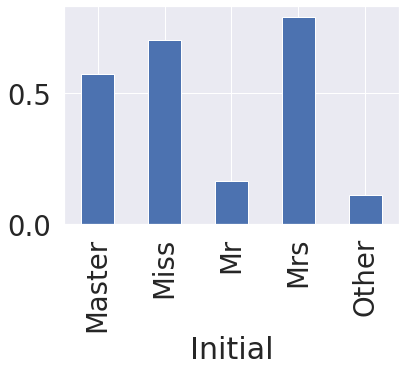

In [ ]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 Null data 를 채우자
- Null data 를 채우는 방법은 statistics 를 활용하는 방법과 null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣은 방식도 있습니다.
- 지금은 statistics 를 이용하여 채우고, statistics 는 train data 의 것을 의미합니다. 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train statistics 를 기반으로 test의 null data 를 채워야 합니다.

In [ ]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용하여 Null value 를 채워보자.
- pandas dataframe 을 다룰때에는 boolean array를 이용해 indexing 하는 방법이 편리하다.

In [ ]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

- 코드 첫줄을 해석하면 'isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다' 입니다.
- loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해져야한다.
- 여기서는 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재한다.
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 보시면서 공부해보자!


#### 3.1.2 Fill Null in Embarked

In [ ]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has  2 Null values


In [ ]:
df_train['Embarked'].fillna('S', inplace=True)

- Embarked 에는 Null value 가 2개 이고, S 에서 가장 많은 탑승객이 있었으므로, 단순하게 Null 을 S로 채우자.
- dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됩니다

### 3.2 Chage Age(continuous to categorical)
- Age 는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만, Agge 를 몇개의 group로 나누어 category 화 시켜줄 수 도 있습니다. continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있습니다.
- 이 튜토리얼과정은 다양한 방법을 소개합니다.

In [ ]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

- 첫번째로 loc 를 사용한 방법입니다. loc 는 자주 사용하므로 숙지하면 좋습니다.
- 나이는 10살 간격으로 나눕니다.

In [ ]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

- 두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다. 훨씬 쉽다.
- 두가지 방법이 잘 적용됐다면, 둘다 같은 결과를 내야한다.
- 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용하자
 - all() 메소드는 모든 값이 True면 True 하나라도 False를 줍니다 


In [ ]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True  -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True  ->  True


- True가 나온다면 둘 중 편한걸 선택
- False가 나온다면 3.1 과정을 다시하기

In [ ]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

- 중복되는 Age_cat 컬럼과 원래 컬럼 Age를 제거하자

### 3.3 Change Initial, Embarked and Sex (string to numerical)
- 현재 Initial 은 Mr, Mrs, Miss, Master, Other 으로 총 5개로 으루어져 있습니다.
- 이런 카테고리로 표현된 데이터를 모델에 넣어줄때 우리가 해야할 일은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
- map method 를 사용해보자.


In [ ]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss' : 1,'Mr': 2, 'Mrs': 3, "Other": 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss' : 1,'Mr': 2, 'Mrs': 3, "Other": 4})

- 사전 순서대로 정리하여 mapping

- Embarked 도 C, Q, S로 이루어져 있는데 map 을 사용하여 바꿔보자
- 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다.
- unique() 메소드를 사용하거나 value_counts() 를 사용하여 count 까지 보는 방법도 있습니다.

In [ ]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [ ]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

- 위 두 방법으로 Embarked가 S, C, Q 세가지로 이루어진 것을 확인
- 이제 map를 활용해보자

In [ ]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [ ]:
df_train['Embarked']

0      2
1      0
2      2
3      2
4      2
      ..
886    2
887    2
888    2
889    0
890    1
Name: Embarked, Length: 891, dtype: int64

In [ ]:
df_train['Embarked'].isnull().any()

False

- Null이 사라졌는지 확인
- isnull() 메소드를 사용해서 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다.
- any() 를 이용하여 Null이 한개라도 있을시 True, Null이 없을 시엔 False를 반환하게 됩니다.
- Null이 없으므로 False반환

In [ ]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

- Sex 도 map를 이용하여 바꿔봅시다.

- 이제 각 feature 간의 상관관계를 한번 보려고 합니다. 
- 두 변수간의 Pearson conrrelation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다.

- 우리는 여러 feature 를 가지고 있으니 이를 maxtrix 형태로 보면 편한데  이를 heatmap plot 이라고 합니다.
- dataframe의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

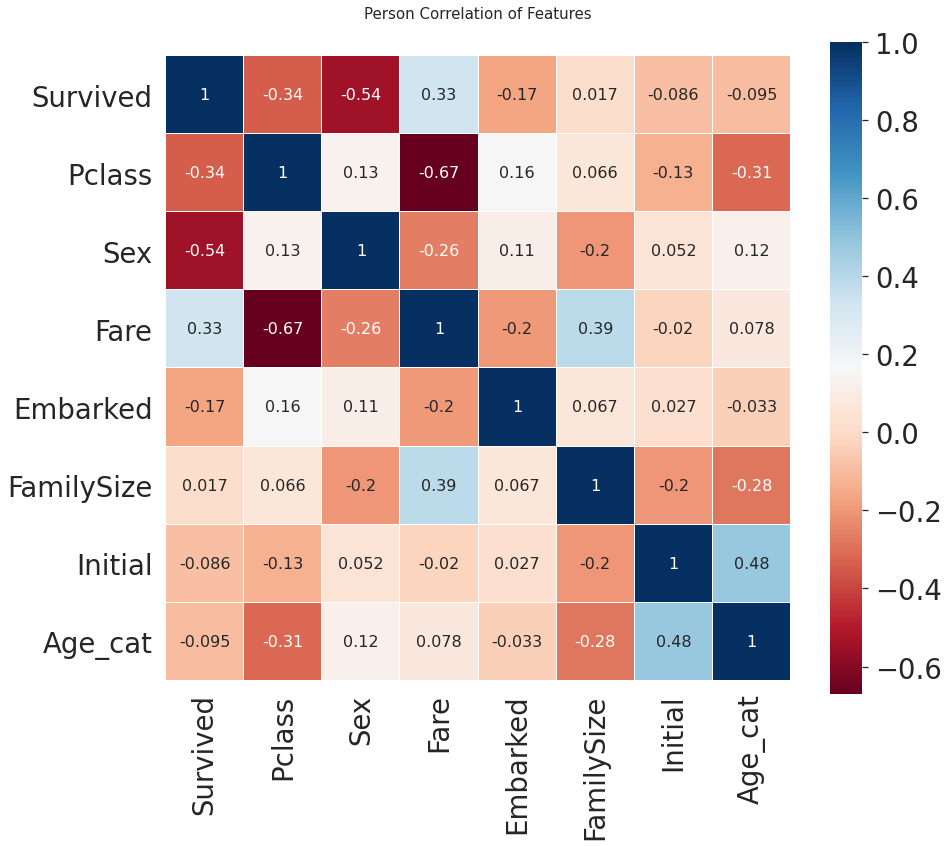

In [ ]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Features', y=1.05, size= 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})
del heatmap_data

- EDA에서 살펴 보았듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 알 수 있습니다.
- 생각보다 Fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
- 또한 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 갖는 feature들이 없다는 것입니다.
- 이것은 불필요한 feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 것 입니다.
- 이제 실제로 모델을 학습시키기 앞서서 data preprocessing(전처리)을 진행해보겠습니다.

### 3.4 One-hot encoding on Initial and Embarked
- 수치화한 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 One-hot encoding을 해줄 수 있습니다.
- 수치화는 간단히 Master: 0, Miss: 1, Mr: 2, Mrs: 3, Other: 4로 매핑

- 직접 코딩하기 보다는 pandas 의 get_dummies 를 사용하여 쉽게 해볼 수 있다.
- 총 5개의 카테고리 이므로 one-hot encoding 을 하고 나면 5개의 column이 생깁니다.
- Initial 을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [ ]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


- 우리가 만들려고 했던 one-hot Columns가 생성된 것을 확인
- Embarked 에도 적용하기

In [ ]:
df_train = pd.get_dummies(df_train,columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test,columns=['Embarked'], prefix='Embarked')

- one-hot encoding 적용완료

### 3.5 Drop columns

In [ ]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket',
               'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket',
               'Cabin'], axis=1, inplace=True)

- 필요없는 columns 제거

In [ ]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [ ]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


## 4. Building marchine learning model and prediction using the trained model
- sklearn을 사용해 머신러닝 모델을 만들어보자
- 타이타닉 문제는 target class(Survived)가 있으며, target class는 0, 1로 이루어져 있으므로 binary classfication 문제입니다.
- 우리가 가지고 있는 train set 의 Survived를 제외한 Input 을 가지고 모델을 최적화 시켜서 각 샘플(탑승객)의 생존 유무를 판단하는 모델을 만들어 냅니다.
- 그 후 모델이 학습하지 않았던 test set 을 input 으로 줘서 test set 의 각 샘플 (탑승객)의 생존 유무를 예측해봅니다.

In [ ]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

- 설명
 - 모델은 RandomForestClassifier
 - metrics는 모델의 평가를 위해 사용합니다.
 - train_test_split는 traning set을 쉽게 나눠주는 함수입니다.




### 4.1 Preparation - Split dataset into train, valid, test set
- 랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다. 더 구체적인 모델 설명은 여러 블로그들 참고하시면 될 것이고, 저도 한번 추후 다뤄보겠습니다.
- 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다.

In [ ]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [ ]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2021)

- train_test_split 을 사용하여 쉽게 train 셋을 분리할 수 있습니다.

### 4.2 Model generation and prediction

In [ ]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [ ]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 78.73% 정확도로 생존을 맞춤


### 4.3 Feature improtance
- 학습된 모델은 기본적으로 feature importances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다
- pandas series 를 이용하여 sorting 을 하여 그래프를 그릴 수 있습니다.

In [ ]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

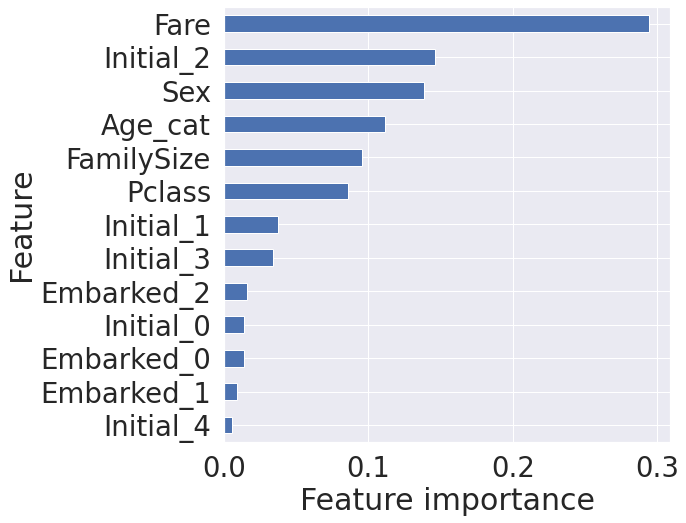

In [ ]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- 우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로는 Initial_2, Age_cat, Pclass가 순으로 중요도를 가집니다.
- 이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수도 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 조금 더 통계적을 살펴봐야 합니다.

### 4.4 Prediction on Test set
- 이제 학습하지 않았던 테스트셋을 모델에 주어서, 생존여부를 예측해보겠습니다.
- 캐글에서 준 파일, gender_submission.csv 파일을 일겅서 제출 준비를 하겠습니다.

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


- 이제 testset 에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠습니다.

In [ ]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [ ]:
submission.to_csv('first_submission.csv', index=False)